# TensorFlow Convolutional Neural Network for Image Classification

In [1]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import dataset
import cv2

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

## Configuration and Hyperparameters

In [2]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
# classes = ['dogs', 'cats']
classes = ['1-', '2', '3+']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

# train_path = '../../data_dogs_vs_cats/train/'
# test_path = '../../data_dogs_vs_cats/test/'
train_path = '../../../../20201020134002/dataset/'
test_path = '../../../../20201020134002/Aria1/'
checkpoint_dir = "models/"

## Load Data

In [3]:
data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)

Reading training images
Loading 1- files (Index: 0)
Loading 2 files (Index: 1)
Loading 3+ files (Index: 2)


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		672
- Validation-set:	128


### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid (or fewer, depending on how many images are passed), and writing the true and predicted classes below each image.

In [5]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(14, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        ax.imshow(np.array(image))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

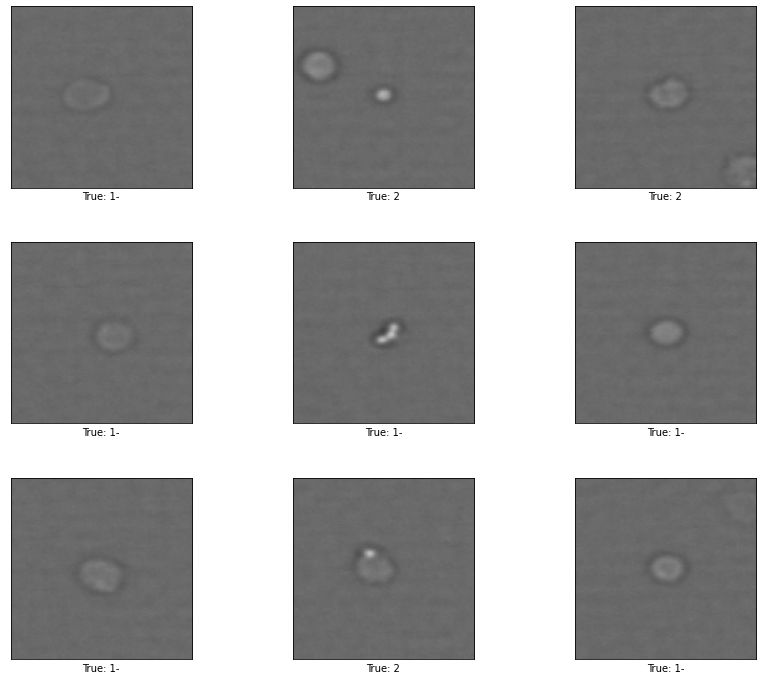

In [6]:
# Get some random images and their labels from the train set.

images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

### Model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(num_filters1, filter_size1, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04),
                           input_shape=(img_size, img_size, num_channels)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(num_filters2, filter_size2, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(num_filters3, filter_size3, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(fc_size, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

## TensorFlow Run

### Helper-function to perform optimization iterations

It takes a long time to calculate the gradient of the model using the entirety of a large dataset
. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [8]:
train_batch_size = batch_size

In [9]:
def print_progress(epoch, train_acc, val_acc, val_loss):
    msg = f"Epoch {epoch} --- Training Accuracy: {train_acc:>6.1%}, Validation Accuracy: {val_acc:>6.1%}, Validation Loss: {val_loss:.3f}"
    print(msg)

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [10]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def train(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations, total_iterations + num_iterations):
        # Reset the metric accumulators
        model.reset_metrics()

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        result = model.train_on_batch(x_batch, y_true_batch) 
        train_acc = result[1]

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss, val_acc = model.test_on_batch(x_valid_batch, y_valid_batch, reset_metrics=False)
            epoch = int(i / int(data.train.num_examples/batch_size))
            metrics_names = model.metrics_names
            
            print_progress(epoch, train_acc, val_acc, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [11]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]

    # Plot the first 9 images.
    plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred)

### Helper-function to plot confusion matrix

In [12]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [13]:
def print_validation_accuracy(show_example_errors=False, show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.valid.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :]
        

        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = np.argmax(model(images), 1)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance after 1 optimization iteration

In [14]:
train(num_iterations=1)
print_validation_accuracy()

Epoch 0 --- Training Accuracy:  78.1%, Validation Accuracy:  75.0%, Validation Loss: 4.212
Time elapsed: 0:00:01
Accuracy on Test-Set: 72.7% (93 / 128)


## Performance after 100 optimization iterations

After 100 optimization iterations, the model should have significantly improved its classification accuracy.

In [15]:
train(num_iterations=99)  # We already performed 1 iteration above.

Epoch 1 --- Training Accuracy:  78.1%, Validation Accuracy:  84.4%, Validation Loss: 3.596
Epoch 2 --- Training Accuracy:  78.1%, Validation Accuracy:  71.9%, Validation Loss: 3.623
Epoch 3 --- Training Accuracy:  78.1%, Validation Accuracy:  59.4%, Validation Loss: 3.704
Epoch 4 --- Training Accuracy:  78.1%, Validation Accuracy:  75.0%, Validation Loss: 3.285
Time elapsed: 0:00:29


Accuracy on Test-Set: 72.7% (93 / 128)
Example errors:


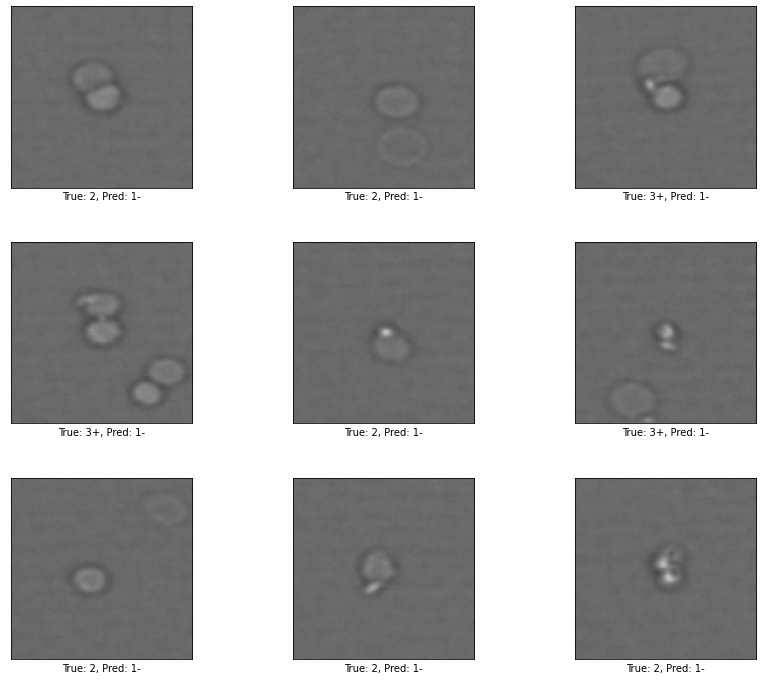

In [16]:
print_validation_accuracy(show_example_errors=True)

## Performance after 1000 optimization iterations

In [17]:
train(num_iterations=900)  # We performed 100 iterations above.

Epoch 5 --- Training Accuracy:  78.1%, Validation Accuracy:  84.4%, Validation Loss: 2.950
Epoch 6 --- Training Accuracy:  78.1%, Validation Accuracy:  71.9%, Validation Loss: 2.987
Epoch 7 --- Training Accuracy:  78.1%, Validation Accuracy:  59.4%, Validation Loss: 3.084
Epoch 8 --- Training Accuracy:  78.1%, Validation Accuracy:  75.0%, Validation Loss: 2.699
Epoch 9 --- Training Accuracy:  78.1%, Validation Accuracy:  84.4%, Validation Loss: 2.387
Epoch 10 --- Training Accuracy:  78.1%, Validation Accuracy:  71.9%, Validation Loss: 2.470
Epoch 11 --- Training Accuracy:  78.1%, Validation Accuracy:  59.4%, Validation Loss: 2.606
Epoch 12 --- Training Accuracy:  78.1%, Validation Accuracy:  75.0%, Validation Loss: 2.247
Epoch 13 --- Training Accuracy:  78.1%, Validation Accuracy:  84.4%, Validation Loss: 1.967
Epoch 14 --- Training Accuracy:  78.1%, Validation Accuracy:  71.9%, Validation Loss: 2.079
Epoch 15 --- Training Accuracy:  78.1%, Validation Accuracy:  59.4%, Validation Loss:

Accuracy on Test-Set: 72.7% (93 / 128)
Example errors:


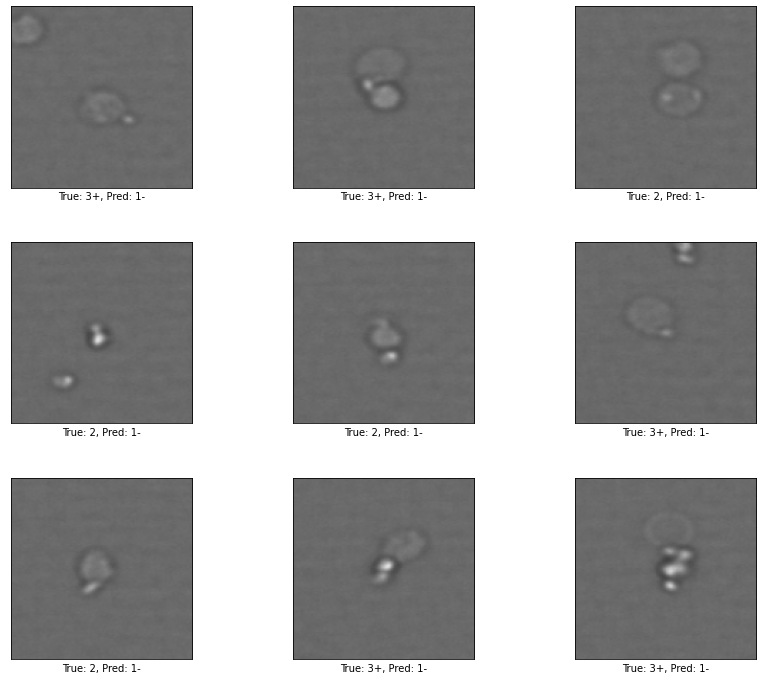

In [18]:
print_validation_accuracy(show_example_errors=True)

## Performance after 7,500 optimization iterations

In [19]:
train(num_iterations=6500) # We performed 1000 iterations above.

Epoch 48 --- Training Accuracy:  78.1%, Validation Accuracy:  75.0%, Validation Loss: 0.913
Epoch 49 --- Training Accuracy:  78.1%, Validation Accuracy:  84.4%, Validation Loss: 0.773
Epoch 50 --- Training Accuracy:  78.1%, Validation Accuracy:  71.9%, Validation Loss: 0.956
Epoch 51 --- Training Accuracy:  78.1%, Validation Accuracy:  59.4%, Validation Loss: 1.059
Epoch 52 --- Training Accuracy:  78.1%, Validation Accuracy:  75.0%, Validation Loss: 0.872
Epoch 53 --- Training Accuracy:  78.1%, Validation Accuracy:  84.4%, Validation Loss: 0.749
Epoch 54 --- Training Accuracy:  78.1%, Validation Accuracy:  71.9%, Validation Loss: 0.935
Epoch 55 --- Training Accuracy:  78.1%, Validation Accuracy:  59.4%, Validation Loss: 1.019
Epoch 56 --- Training Accuracy:  78.1%, Validation Accuracy:  75.0%, Validation Loss: 0.844
Epoch 57 --- Training Accuracy:  78.1%, Validation Accuracy:  84.4%, Validation Loss: 0.741
Epoch 58 --- Training Accuracy:  78.1%, Validation Accuracy:  71.9%, Validation 

Epoch 137 --- Training Accuracy:  87.5%, Validation Accuracy:  81.2%, Validation Loss: 0.719
Epoch 138 --- Training Accuracy:  87.5%, Validation Accuracy:  68.8%, Validation Loss: 1.009
Epoch 139 --- Training Accuracy:  87.5%, Validation Accuracy:  71.9%, Validation Loss: 0.892
Epoch 140 --- Training Accuracy:  87.5%, Validation Accuracy:  78.1%, Validation Loss: 0.780
Epoch 141 --- Training Accuracy:  87.5%, Validation Accuracy:  81.2%, Validation Loss: 0.726
Epoch 142 --- Training Accuracy:  87.5%, Validation Accuracy:  68.8%, Validation Loss: 1.010
Epoch 143 --- Training Accuracy:  87.5%, Validation Accuracy:  71.9%, Validation Loss: 0.889
Epoch 144 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.782
Epoch 145 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.729
Epoch 146 --- Training Accuracy:  90.6%, Validation Accuracy:  71.9%, Validation Loss: 1.010
Epoch 147 --- Training Accuracy:  90.6%, Validation Accuracy:  71.9%, 

Epoch 226 --- Training Accuracy:  93.8%, Validation Accuracy:  68.8%, Validation Loss: 1.051
Epoch 227 --- Training Accuracy:  93.8%, Validation Accuracy:  71.9%, Validation Loss: 0.832
Epoch 228 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.746
Epoch 229 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.732
Epoch 230 --- Training Accuracy:  93.8%, Validation Accuracy:  68.8%, Validation Loss: 1.057
Epoch 231 --- Training Accuracy:  93.8%, Validation Accuracy:  71.9%, Validation Loss: 0.808
Epoch 232 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.762
Epoch 233 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.753
Epoch 234 --- Training Accuracy:  93.8%, Validation Accuracy:  68.8%, Validation Loss: 1.057
Epoch 235 --- Training Accuracy:  93.8%, Validation Accuracy:  71.9%, Validation Loss: 0.830
Epoch 236 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, 

Epoch 315 --- Training Accuracy:  93.8%, Validation Accuracy:  71.9%, Validation Loss: 0.859
Epoch 316 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.814
Epoch 317 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.858
Epoch 318 --- Training Accuracy:  93.8%, Validation Accuracy:  68.8%, Validation Loss: 1.119
Epoch 319 --- Training Accuracy:  93.8%, Validation Accuracy:  71.9%, Validation Loss: 0.862
Epoch 320 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.815
Epoch 321 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.855
Epoch 322 --- Training Accuracy:  93.8%, Validation Accuracy:  68.8%, Validation Loss: 1.120
Epoch 323 --- Training Accuracy:  93.8%, Validation Accuracy:  71.9%, Validation Loss: 0.862
Epoch 324 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.819
Epoch 325 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, 

Accuracy on Test-Set: 77.3% (99 / 128)
Example errors:


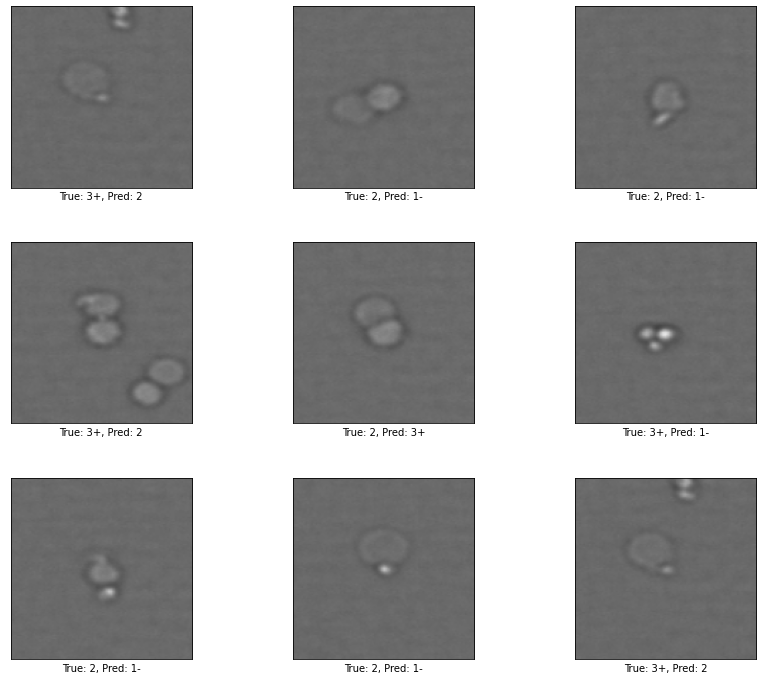

Confusion Matrix:
[[90  1  2]
 [16  3  3]
 [ 4  3  6]]


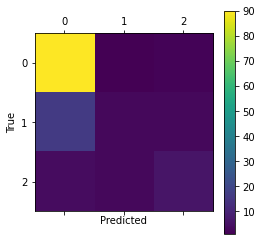

In [20]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

## Test on Sample Image

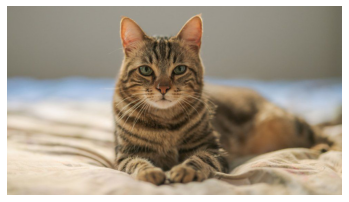

In [21]:
plt.axis('off')

test_cat = cv2.imread('cat.jpg')

plt.imshow(cv2.cvtColor(test_cat, cv2.COLOR_BGR2RGB))
plt.show()

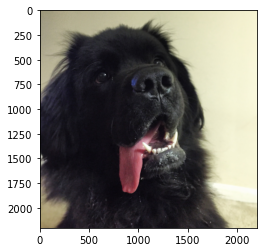

In [22]:
test_dog = cv2.imread('dog.jpg')

plt.imshow(cv2.cvtColor(test_dog, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
def sample_prediction(test_im):
    test_im = cv2.resize(test_im, (img_size, img_size), cv2.INTER_LINEAR) / 255
    test_pred = np.argmax(model(test_im.reshape((1, img_size, img_size, 3))))
    return classes[test_pred]

print("Predicted class for test_cat: {}".format(sample_prediction(test_cat)))
print("Predicted class for test_dog: {}".format(sample_prediction(test_dog)))

Predicted class for test_cat: 1-
Predicted class for test_dog: 2
